# **Initializing libraries and data**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats import norm
from collections import Counter
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.linear_model import  Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import  RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from google.colab import drive

drive.mount('/content/drive')
 


ModuleNotFoundError: ignored

In [ ]:
df_train = pd.read_csv('drive/My Drive/houseprices_train.csv')
df_test = pd.read_csv('drive/My Drive/houseprices_test .csv')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.00,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.00,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.00,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.00,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.00,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
print("The train data size before dropping Id feature is : {} ".format(df_train.shape))
print("The test data size before dropping Id feature is : {} ".format(df_test.shape))

train_ID = df_train['Id']
test_ID = df_test['Id']
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

print("The train data size after dropping Id feature is : {} ".format(df_train.shape))
print("The test data size after dropping Id feature is : {} ".format(df_test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 
The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


# **Analyzing target value**

In [ ]:
df_train['SalePrice'].describe()

count     1460.00
mean    180921.20
std      79442.50
min      34900.00
25%     129975.00
50%     163000.00
75%     214000.00
max     755000.00
Name: SalePrice, dtype: float64

With an average house price of $180921


 mu = 180921.20 and sigma = 79415.29



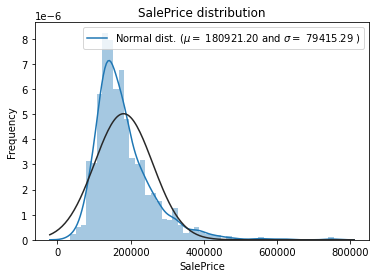

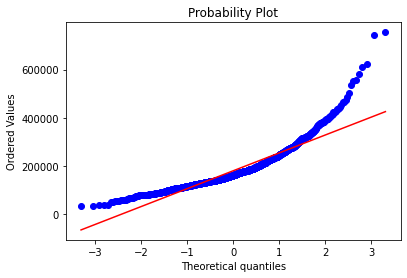

In [ ]:
sns.distplot(df_train['SalePrice'] , fit=norm);


(mu, sigma) = norm.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

In [ ]:
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


Doesnt look like normal distribution. We can see that the sale prices deviate from the normal distribution.

# **Multivariable Analysis**

In [ ]:
df_train.select_dtypes(include=['object']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [ ]:
df_train.select_dtypes(include=['int64','float64']).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [ ]:
cat = len(df_train.select_dtypes(include=['object']).columns)
num = len(df_train.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')

Total Features:  43 categorical + 37 numerical = 80 features


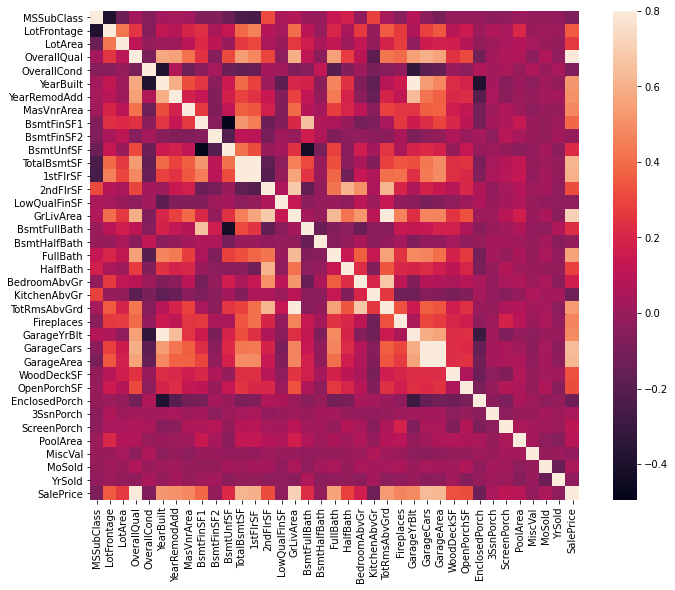

In [ ]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

A lot of data to look at. Zoom into the top 15 features most related to Sale Price.

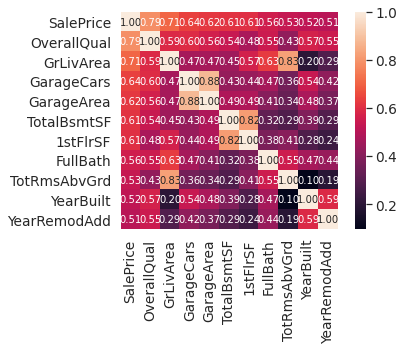

In [ ]:
k = 11
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,SalePrice
1,OverallQual
2,GrLivArea
3,GarageCars
4,GarageArea
5,TotalBsmtSF
6,1stFlrSF
7,FullBath
8,TotRmsAbvGrd
9,YearBuilt




*   OverallQual: Rates the overall material and finish of the house (1 = Very Poor, 10 = Very Excellent)
* GrLivArea: Above grade (ground) living area square feet
* GarageCars: Size of garage in car capacity
* GarageArea: Size of garage in square feet
* TotalBsmtSF: Total square feet of basement area
* 1stFlrSF: First Floor square feet
* FullBath: Full bathrooms above grade
* TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
* YearBuilt: Original construction date
* YearRemodAdd: Remodel date

Take a look at how each relates to Sale Price and do some cleaning if neccesary.

- Overall Quality vs Sale Price

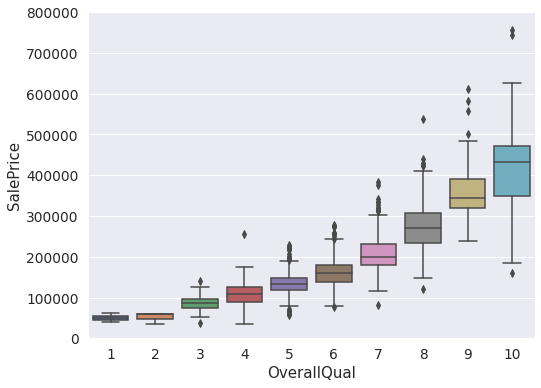

In [ ]:
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

People pay more for better quality

- Living Area vs Sale Price

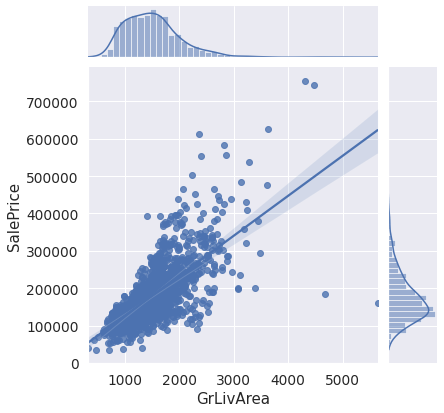

In [ ]:
sns.jointplot(x=df_train['GrLivArea'], y=df_train['SalePrice'], kind='reg')

People pay more for more living are but we have some outliers, we can clean them up manually.

In [ ]:
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index).reset_index(drop=True)

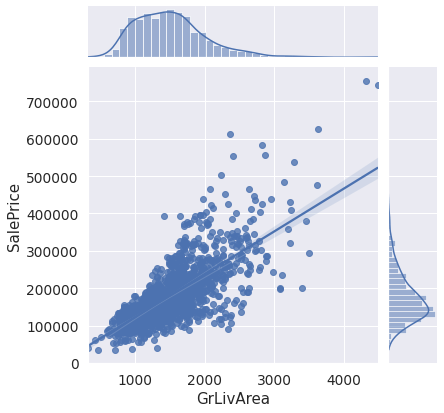

In [ ]:
sns.jointplot(x=df_train['GrLivArea'], y=df_train['SalePrice'], kind='reg')

We got a 0.02 point increase in the Pearson-R Score.

- Garage Area vs Sale Price

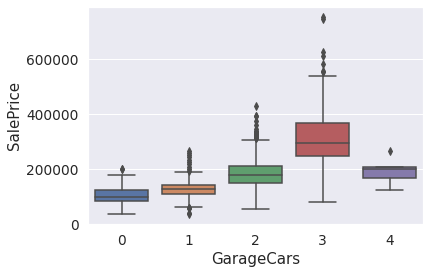

In [ ]:
sns.boxplot(x=df_train['GarageCars'], y=df_train['SalePrice'])

Remove those outliers tha have more garage room and less expensive

In [ ]:
df_train = df_train.drop(df_train[(df_train['GarageCars']>3) & (df_train['SalePrice']<300000)].index).reset_index(drop=True)

- Garage Area vs Sale Price

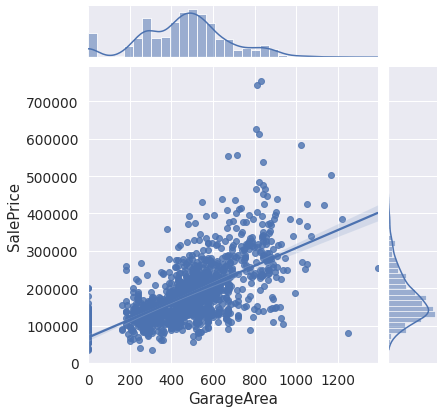

In [ ]:
sns.jointplot(x=df_train['GarageArea'], y=df_train['SalePrice'], kind='reg')

Remove bottom outliers that have more garage room and less expensive.

In [ ]:
df_train = df_train.drop(df_train[(df_train['GarageArea']>1000) & (df_train['SalePrice']<300000)].index).reset_index(drop=True)

- Basement Area vs Sale Price

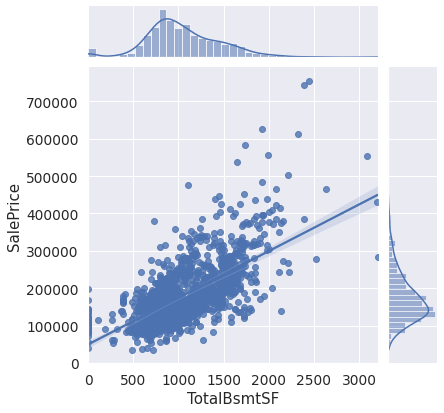

In [ ]:
sns.jointplot(x=df_train['TotalBsmtSF'], y=df_train['SalePrice'], kind='reg')

- First Floor Area vs Sale Price

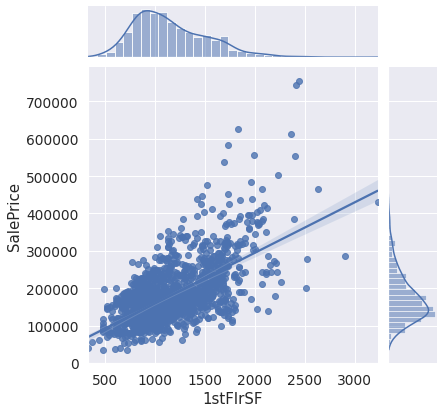

In [ ]:
sns.jointplot(x=df_train['1stFlrSF'], y=df_train['SalePrice'], kind='reg')

Total Rooms vs Sale Price

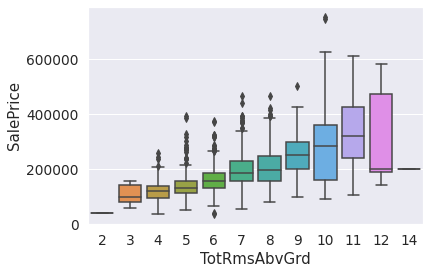

In [ ]:
sns.boxplot(x=df_train['TotRmsAbvGrd'], y=df_train['SalePrice'])

FullBath vs Sale Price

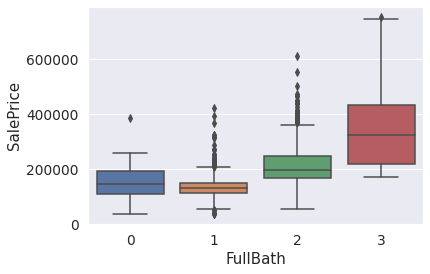

In [ ]:
sns.boxplot(x=df_train['FullBath'], y=df_train['SalePrice'])

TotRmsAbvGrd vs Sale Price

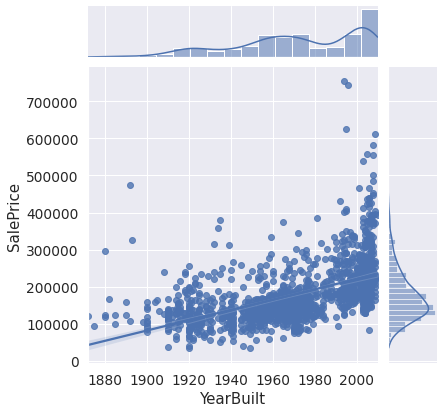

In [ ]:
sns.jointplot(x=df_train['YearBuilt'], y=df_train['SalePrice'], kind='reg')

YearRemodAdd vs Sale Price

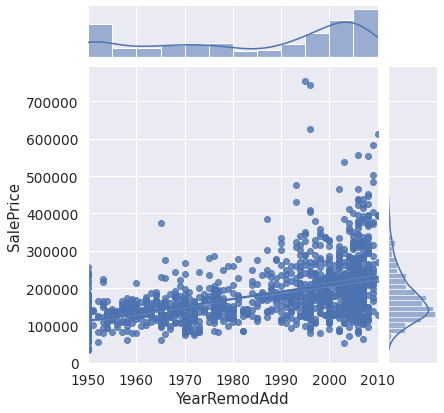

In [ ]:
sns.jointplot(x=df_train['YearRemodAdd'], y=df_train['SalePrice'], kind='reg')

Everything look relatively fine for last 6 graphs.

# **Cleaning Data and Missing Data**

In [ ]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
y_train = df_train.SalePrice.values
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("Train data size is : {}".format(df_train.shape))
print("Test data size is : {}".format(df_test.shape))
print("Combined dataset size is : {}".format(all_data.shape))

Train data size is : (1448, 80)
Test data size is : (1459, 79)
Combined dataset size is : (2907, 79)


Text(0.5, 1.0, 'Percent missing data by feature')

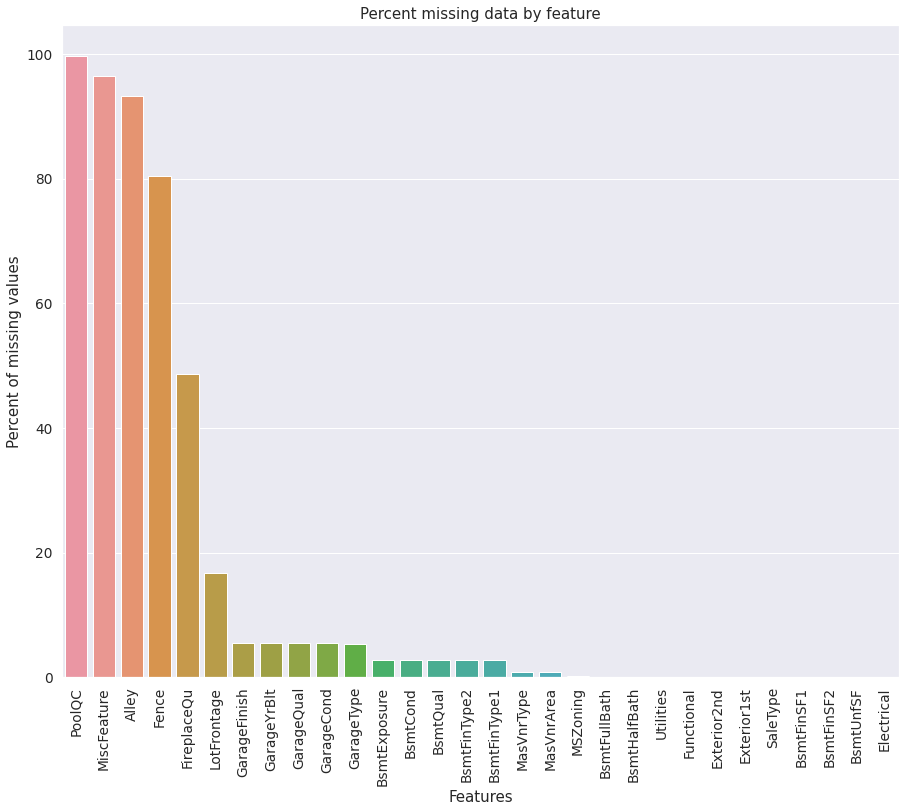

In [ ]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

* PoolQC : data description says NA means "No Pool"
* MiscFeature : data description says NA means "no misc feature"
* Alley : data description says NA means "no alley access"
* Fence : data description says NA means "no fence"
* FireplaceQu : data description says NA means "no fireplace"
* LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.
* GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with "None".
* GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0.
* BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath:  Replacing missing data with 0.
* BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : For all these categorical basement-related features, NaN means that there isn't a basement.
* MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.
* MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'.
* Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
* Functional : data description says NA means typical.
* Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
* KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
* Exterior1st and Exterior2nd : Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
* SaleType : Fill in again with most frequent which is "WD"
* MSSubClass : Na most likely means No building class. We can replace missing values with None

In [ ]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [ ]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


# **Feature Engineering**

MSSubClass: Identifies the type of dwelling involved in the sale.

In [ ]:
all_data['MSSubClass'].describe()

count   2907.00
mean      57.09
std       42.51
min       20.00
25%       20.00
50%       50.00
75%       70.00
max      190.00
Name: MSSubClass, dtype: float64

Average is a 57 type. 90 type is not 3 times better than a 30 type.
So we can change this column type to object.

OverallCond

In [ ]:
all_data['OverallCond'].describe()

count   2907.00
mean       5.57
std        1.11
min        1.00
25%        5.00
50%        5.00
75%        6.00
max        9.00
Name: OverallCond, dtype: float64

YrSold

In [ ]:
all_data['YrSold'].describe()

count   2907.00
mean    2007.79
std        1.32
min     2006.00
25%     2007.00
50%     2008.00
75%     2009.00
max     2010.00
Name: YrSold, dtype: float64

MoSold

In [ ]:
all_data['MoSold'].describe()

count   2907.00
mean       6.21
std        2.71
min        1.00
25%        4.00
50%        6.00
75%        8.00
max       12.00
Name: MoSold, dtype: float64

- Changing these variables to categorical variable.

In [ ]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [ ]:
all_data['KitchenQual'].unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

Let's encode these labels to specific orrder.

In [ ]:

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# Check shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2907, 78)


Creating a feature for total area.

In [ ]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

- Normalize the SalePrice target feature by log transform.

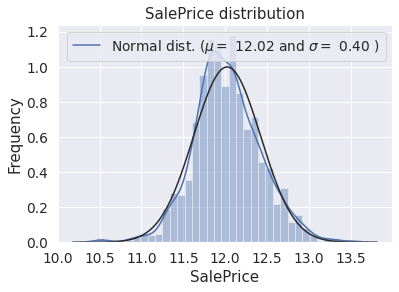

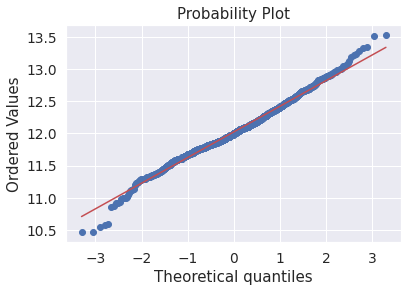

Skewness: 0.130172
Kurtosis: 0.822862


In [ ]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

#Check the new distribution 
sns.distplot(df_train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['SalePrice'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

y_train = df_train.SalePrice.values

print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

- Checking skewnes of all numerical features

In [ ]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
skewness.head()

,Skewed Features
MiscVal,21.91
PoolArea,17.66
LotArea,13.15
LowQualFinSF,12.06
3SsnPorch,11.35


- Boxcox log transformation for skewed

In [ ]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    all_data[feat] += 1

There are 59 skewed numerical features to Box Cox transform


In [ ]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2907, 220)


- Splitting train and test data

In [ ]:
train = all_data[:ntrain]
test = all_data[ntrain:]
y_train.shape

(1448,)

In [ ]:
train.shape

(1448, 220)

# **Trying Machine Learning Models**

- Random Mean Square Logarithmic Error with Cross validation

In [ ]:
n_folds = 10

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

- Creating models using lasso, elastic net, kernel ridge, gradient boosting, XGBoost and LightGBM regression. Using Robust scaler

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0003, random_state=123))


ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0003, l1_ratio=.9, random_state=123))


ridge = Ridge(alpha=0.6)


GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.01,max_depth=4, max_features='sqrt',min_samples_leaf=15, min_samples_split=10,loss='huber', random_state =123)


model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0,learning_rate=0.05, max_depth=6,min_child_weight=1.5, n_estimators=7200,reg_alpha=0.9, reg_lambda=0.6, subsample=0.2,seed=42, silent=1,random_state =123)


model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,learning_rate=0.01, n_estimators=720,max_bin = 55, bagging_fraction = 0.8, bagging_freq = 5, feature_fraction = 0.2319, feature_fraction_seed=9, bagging_seed=9, min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [ ]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ridge)
print("Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.1092 (0.0142)

ElasticNet score: 0.1094 (0.0143)

Ridge score: 0.1164 (0.0165)

Gradient Boosting score: 0.1118 (0.0154)

Xgboost score: 0.1161 (0.0143)

LGBM score: 0.1212 (0.0130)



It looks like we have Lasso best so far.

- XGboost Grids Search

In [ ]:
xgb1 = XGBRegressor()
parameters = {'nthread':[-1], 
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500],'metrics':[rmse],'alpha':np.arange(0.01, 0.2, 0.01)}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(train,
         y_train)
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)


Fitting 2 folds for each of 171 candidates, totalling 342 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  7.8min
[Parallel(n_jobs=5)]: Done 342 out of 342 | elapsed: 14.0min finished


0.9065935009284055
{'alpha': 0.01, 'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'metrics': 0.13150065721676787, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


0.9065935009284055

{'alpha': 0.01, 'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'metrics': 0.13150065721676787, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}

- LGBM


In [ ]:
params = {
    'nthread':[4],
    'application': 'regression', 
    'boosting': 'gbdt', 
    'num_iterations': 100, 
    'learning_rate': 0.05,
    'num_leaves': 62,
    'device': 'cpu',
    'max_depth': 50, 
    'max_bin': 510, 
    'lambda_l1': 5, 
    'lambda_l2': 10, 
    'metric' : 'binary_error',
    'subsample_for_bin': 200, 
    'subsample': 1, 
    'colsample_bytree': 0.8, 
    'min_split_gain': 0.5, 
    'min_child_weight': 1, 
    'min_child_samples': 5,
    'metric': 'rmse'
}

mdl = lgb.LGBMRegressor(boosting_type= 'gbdt', 
          objective = 'binary', 
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'], 
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'], 
          min_split_gain = params['min_split_gain'], 
          min_child_weight = params['min_child_weight'], 
          min_child_samples = params['min_child_samples'])

gridParams = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [8,16,24],
    'num_leaves': [6,8,12,16], 
    'boosting_type' : ['gbdt', 'dart'], 
    'objective' : ['binary'],
    'max_bin':[255, 510], 
    'random_state' : [500],
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

grid = GridSearchCV(mdl, gridParams, verbose=1, cv=4, n_jobs=-1)

grid.fit(train, y_train)

print(grid.best_params_)
print(grid.best_score_)

Fitting 4 folds for each of 3456 candidates, totalling 13824 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 1764 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 3164 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 4964 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 7164 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 9764 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 12764 tasks      | elapsed:  3.8min


{'boosting_type': 'gbdt', 'colsample_bytree': 0.64, 'learning_rate': 0.005, 'max_bin': 255, 'n_estimators': 8, 'num_leaves': 6, 'objective': 'binary', 'random_state': 500, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}
-772.1902377263052


[Parallel(n_jobs=-1)]: Done 13824 out of 13824 | elapsed:  4.1min finished


In [ ]:
optimised_lgbm = grid.best_estimator_

In [ ]:
y_predictlgbm = optimised_lgbm.predict(train)

rmse = np.sqrt(mean_squared_error(y_train, y_predictlgbm))
print("RMSE: %f" % (rmse))

RMSE: 11.030129


- Random Forest

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [ 90, 100, 110],
    'max_features': [5, 7],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [ 300, 500]
}
rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(train, y_train)
print(grid_search.best_params_)

optimised_randomforest = grid_search.best_estimator_
y_predictrf = optimised_randomforest.predict(train)
rmse = np.sqrt(mean_squared_error(y_train, y_predictrf))
print("RMSE: %f" % (rmse))

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  3.0min finished


{'bootstrap': True, 'max_depth': 90, 'max_features': 7, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 500}
RMSE: 0.121525


- Support Vector Machines

In [ ]:
param_grid = {'C': [0.1, 1], 
              'gamma': [1, 0.1, 0.01],
              'kernel': ['linear'],
              'degree':[3]}

grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 3)
  
grid.fit(train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=0.1, degree=3, gamma=1, kernel=linear .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.1, degree=3, gamma=1, kernel=linear, score=0.919, total=   0.9s
[CV] C=0.1, degree=3, gamma=1, kernel=linear .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  C=0.1, degree=3, gamma=1, kernel=linear, score=0.919, total=   0.8s
[CV] C=0.1, degree=3, gamma=1, kernel=linear .........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  C=0.1, degree=3, gamma=1, kernel=linear, score=0.891, total=   0.7s
[CV] C=0.1, degree=3, gamma=1, kernel=linear .........................
[CV]  C=0.1, degree=3, gamma=1, kernel=linear, score=0.910, total=   1.0s
[CV] C=0.1, degree=3, gamma=1, kernel=linear .........................
[CV]  C=0.1, degree=3, gamma=1, kernel=linear, score=0.912, total=   0.7s
[CV] C=0.1, degree=3, gamma=0.1, kernel=linear .......................
[CV]  C=0.1, degree=3, gamma=0.1, kernel=linear, score=0.919, total=   0.8s
[CV] C=0.1, degree=3, gamma=0.1, kernel=linear .......................
[CV]  C=0.1, degree=3, gamma=0.1, kernel=linear, score=0.919, total=   0.8s
[CV] C=0.1, degree=3, gamma=0.1, kernel=linear .......................
[CV]  C=0.1, degree=3, gamma=0.1, kernel=linear, score=0.891, total=   0.7s
[CV] C=0.1, degree=3, gamma=0.1, kernel=linear .......................
[CV]  C=0.1, degree=3, gamma=0.1, kernel=linear, score=0.910, total=   1.0s
[CV] C=0.1, degree=3, gamma=0.1, kernel=linear .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.2min finished


{'C': 0.1, 'degree': 3, 'gamma': 1, 'kernel': 'linear'}
SVR(C=0.1, gamma=1, kernel='linear')


In [ ]:
optimised_svm = grid.best_estimator_
y_predictsvm = optimised_svm.predict(train)
rmse = np.sqrt(mean_squared_error(y_train, y_predictsvm))
print("RMSE: %f" % (rmse))

RMSE: 0.101130


- All Regression Models

In [ ]:
X_train, X_test, y_train_house, y_test_house = train_test_split(train, y_train, random_state=123)
clf = LazyRegressor(verbose=0,ignore_warnings=True)
models, predictions = clf.fit(X_train, X_test, y_train_house, y_test_house)
models

100%|██████████| 42/42 [00:23<00:00,  1.80it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LassoCV,0.79,0.92,0.12,0.74
ElasticNetCV,0.79,0.92,0.12,0.73
LassoLarsCV,0.79,0.92,0.12,0.52
LarsCV,0.79,0.92,0.12,0.78
HuberRegressor,0.79,0.92,0.12,0.47
PoissonRegressor,0.77,0.91,0.13,0.05
BayesianRidge,0.77,0.91,0.13,0.12
OrthogonalMatchingPursuit,0.77,0.91,0.13,0.04
OrthogonalMatchingPursuitCV,0.77,0.91,0.13,0.10


# **Conclusion**

- Various models from above we can see Lasso and SVM are the best for our dataset. Due to high R-square and adjusted R-square we can choose Lasso for last final word.

